# Clustering Clones by Gene Expression

I'm going to try to apply some basic machine learning algorithms to cluster cells into clonotypes based on observations of proteins and gene expression.   

In [1]:
#  Import packages.  Put plots "inline" in the notebook.  

import pandas as pd  # Pandas for data analysis.
import numpy as np  # For numerical computations.
import matplotlib.pyplot as plt  # For plotting.
from sklearn import mixture  # Import Gaussian mixture
%matplotlib inline

Now I read the data from a csv file "clones.csv".
This is the same as the original data file, but transposed.
I'm using Pandas, which is an R-like extension to Python.
The file is read into df, a Pandas data frame.

In [2]:
df = pd.read_csv('clones.csv', sep=',', 
                 index_col=0, header=0, low_memory=False)

df[:5]  # Let's check out the first five rows.

,clonality,cell_number,norm_fsc,all_events_fsc_h_mean,norm_ssc,all_events_ssc_h_mean,cd57,fas,ptprc_cd45ra,cd4,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
P1902_1293,A7,1,88028,57340,92364,50174,71,4569,1219,196,...,0.000000,0.000000,0.0,0.0,0.0,0.053019,0.412588,0.000000,0.000000,0.0
P1902_1294,A7,1,108113,61440,121799,58896,1902,3003,10794,145,...,0.001559,0.000000,0.0,0.0,0.0,0.077060,9.652112,0.000000,0.000000,0.0
P1902_1295,A7,1,101213,59653,98862,50874,2475,10889,5472,-244,...,33.992014,433.919579,0.0,0.0,0.0,0.072747,1.050288,3.292849,24.351262,0.0
P1902_1296,A7,1,99072,59558,102286,53942,78,6617,1678,-96,...,0.000000,1.266188,0.0,0.0,0.0,0.579323,0.174867,0.000000,0.000000,0.0
P1902_1301,A7,1,84219,54797,68003,38394,589,4039,9758,18,...,5.661078,0.000000,0.0,0.0,0.0,0.674957,0.044820,0.000000,0.000000,0.0


I like to summarize things with some verbose commands.

In [4]:
print len(df), "cells are measured."
proteins = list(df.columns[6:15]) # The names of the proteins
# Proteins correspond to columns 6-14 of the data frame.
print len(proteins), "proteins are measured:", proteins
genes = list(df.columns[33:])  # The names of the genes.  
# Genes corresponds to columns 33 onwards in the data frame.
print len(genes), "genes are measured, from",genes[0],"to",genes[-1],"."

345 cells are measured.
9 proteins are measured: ['cd57', 'fas', 'ptprc_cd45ra', 'cd4', 'il7ra', 'dextramer', 'cd3e', 'cd8a', 'ccr7']
19869 genes are measured, from A1BG to ZZZ3 .


##  Gaussian mixture model:  clustering by protein expression

Now that the data is loaded, I'm going to fit the protein data to a Gaussian mixture model.  This isn't the best way if the data is not Gaussian, but it's a starting point.  We'll see how it turns out for classification tasks.

First, we plot the distribution of protein measurements in histograms, just to see whether some are close to Gaussian.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a14ba4450>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1425bc90>]], dtype=object)

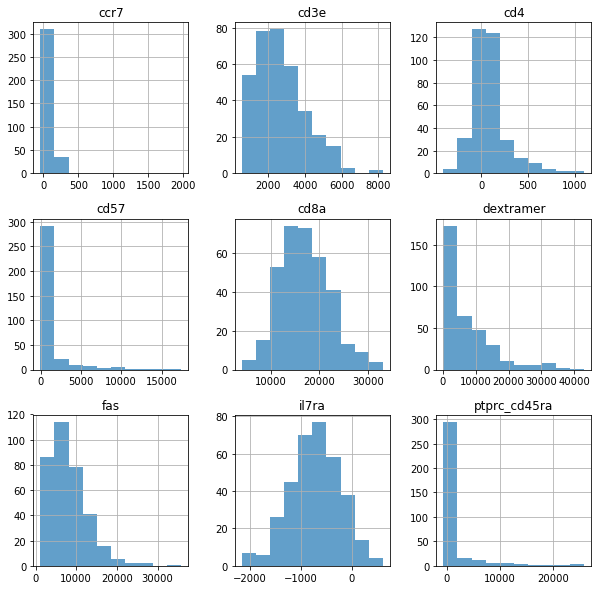

In [5]:
plt.figure();
df.hist(column=proteins, alpha=0.7, figsize=(10,10))

Based on above graphs, the following proteins might be most useful for classification (without log-scaling) They look most Gaussian... but I'm just eyeballing things here.

In [6]:
proteins_useful = ['cd3e', 'cd8a', 'fas', 'cd4', 'il7ra']

Now we make a list of the clonotypes, and a table of their populations.

In [9]:
clones = df['clonality'].unique() 
print 'Clone Population'
print df['clonality'].value_counts()
print '-------------------'
print 'Total population:', len(df)

Clone Population
F3    46
H2    45
E4    44
A7    43
B4    42
H9    33
G8    31
G6    31
A8    30
Name: clonality, dtype: int64
-------------------
Total population: 345


We can analyze whether protein measurements vary by clonotype.
Here we produce histograms of a single protein across all clonotypes.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1487dc10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a157d9410>]], dtype=object)

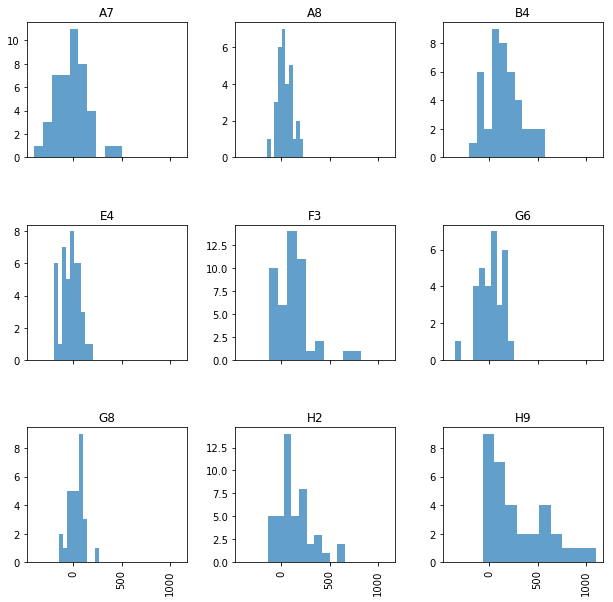

In [10]:
df.hist(column='cd4', by='clonality', figsize = [10,10], 
        sharex = True, sharey = False, alpha=0.7)

## Training and testing

Now we start the modeling for real.  We begin by putting all the protein data into a "dictionary" data structure.  The keys of the dictionary are the clonotypes, and the values are arrays of arrays giving the observation of each (sorta-Gaussian) protein for each cell of that data type.

In [14]:
protein_expression = {}
for c in clones:
    protein_expression[c] = np.array(df[df['clonality'] == c].loc[:,proteins_useful])

# Uncomment the following line, to see the protein expressions for all
# cells of clonotype A7.
# print protein_expression['A7']

In [15]:
# The following two functions will be useful.

def chop(A):
    '''
    Chops a list A into two random pieces,
    of about 75% and 25%.  
    Returns the two pieces, meant for training/testing sets.
    '''
    mask = np.random.choice([True, False], len(A), p=[0.75, 0.25]) # Use 75% training data, 25% testing data.
    notmask = [not b for b in mask]
    return A[mask], A[notmask]

def count_errs(A):
    '''
    Counts the number of elements of A excluding the 
    most frequently occurring one.  For example,
    count_errs([1,1,1,0,1,2,3]) would return 3 (viewing 0,2,3 as errors).
    '''
    AU = np.unique(A)
    corr = max([A.count(j) for j in AU])
    return len(A) - corr

Now we set up training and testing data for protein expression.  Cells of each clonotype are partitioned randomly into training-cells and testing-cells.  The model will be trained on training cells, and validated on testing cells.  This is standard machine-learning stuff.  

The result of training is a Gaussian mixture model that clusters the cells based on protein data alone.  The number of clusters will be given though... there are other techniques (e.g. BIC) one can use to have the computer guess the correct number of clusters.  

For validation, we'll see if the testing cells are clustered according to clonotype, even though the training did not involve clonotype at all!

In [16]:
P_train = {}
P_pred = {}
for c in clones:
    P_train[c], P_pred[c] = chop(protein_expression[c])

In [18]:
test_clones = ['A7','F3', 'G6']  # Let's try to cluster data of these clonotypes.  
#  ------------------------------------------------
#  Change only the above line to see what happens!

# The next line sets up training data.  
# The computer doesn't know the clonotypes in the training data! 
# The computer just knows the protein data for training.
# The computer *will* be given knowledge of the number of clonotypes.
X_train = np.vstack([P_train[c] for c in test_clones]) 
print 'Training set has', len(X_train), 'individuals.'

# Now we use Scikit-Learn to fit a Gaussian Mixture Model 
# with the given number of clonotypes.
# The data gets clustered by clf.fit.
# Just using spherical Gaussians for now.  
# Might be better with ellipses, i.e., full covariance.

clf = mixture.GaussianMixture(n_components=len(test_clones), 
                              covariance_type='spherical')
print clf.fit(X_train)

# Now we use the model to predict the cluster for the cells in the test group.
# We track the number of errors and accuracy.

err_count = sum([count_errs(list(clf.predict(P_pred[c]))) for c in test_clones])
tot_count = sum([len(P_pred[c]) for c in test_clones])
acc = 100 - 100*float(err_count)/tot_count
print err_count, 'errors out of', tot_count,'tests.'
print str(acc)+'% accuracy.'

# Here's the raw output of the validation.  
# It should be a series of arrays, with numbers denoting the assigned cluster.
# With 100% accuracy, each array would have a single number repeated.
# This would mean that cells from each clonotype 
# were assigned to the same cluster.

for c in test_clones:
    print clf.predict(P_pred[c])

Training set has 86 individuals.
GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=3, n_init=1,
        precisions_init=None, random_state=None, reg_covar=1e-06,
        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None)
11 errors out of 34 tests.
67.6470588235% accuracy.
[0 0 0 0 0 0 2 2 1 0 0]
[1 1 1 1 2 2 1 1 1 0 1 2 1 0 1]
[2 2 1 2 0 2 0 2]


Now let's do the same as above, but with less running commentary.  We'll track the accuracy of the clustering for every *pair* of clonotypes.  E.g., can protein measurements distinguish clonotype A7 from A8?  How well?  How about A7 from H9?  We'll give the average (among all pairs) accuracy at the end.

In [34]:
S = 0
n = 0
data = np.zeros((len(clones), len(clones)))

for c1 in range(len(clones)-1):
    for c2 in range(c1 + 1, len(clones)):
        test_clones = [clones[c1], clones[c2]]
        X_train = np.vstack([P_train[c] for c in test_clones])
        clf = mixture.GaussianMixture(n_components=len(test_clones), 
                                      covariance_type='spherical')
        clf.fit(X_train)
        err_count = sum([count_errs(list(clf.predict(P_pred[c]))) 
                         for c in test_clones])
        tot_count = sum([len(P_pred[c]) for c in test_clones])
        acc_count = np.round(100 - 100*float(err_count)/tot_count, decimals=2)
        data[c1][c2] = acc_count
        data[c2][c1] = acc_count
        S += acc_count
        n += 1

for d in range(len(clones)):
    data[d][d] = None
    
clone_vs_clone = pd.DataFrame(data, columns=clones, index=clones)
ave_acc = float(S) / n
print '-------------------------'
print 'Average accuracy is '+ str(ave_acc)+'%.'
clone_vs_clone

-------------------------
Average accuracy is 76.5080555556%.


,A7,A8,B4,E4,F3,G6,G8,H2,H9
A7,NaN,100.00,70.00,65.00,84.62,73.68,75.00,72.00,87.50
A8,100.00,NaN,100.00,62.50,90.91,66.67,91.67,85.71,100.00
B4,70.00,100.00,NaN,72.22,83.33,70.59,78.57,73.91,71.43
E4,65.00,62.50,72.22,NaN,62.50,58.82,71.43,82.61,78.57
F3,84.62,90.91,83.33,62.50,NaN,65.22,90.00,72.41,65.00
G6,73.68,66.67,70.59,58.82,65.22,NaN,76.92,63.64,69.23
G8,75.00,91.67,78.57,71.43,90.00,76.92,NaN,68.42,70.00
H2,72.00,85.71,73.91,82.61,72.41,63.64,68.42,NaN,84.21
H9,87.50,100.00,71.43,78.57,65.00,69.23,70.00,84.21,NaN


# Analyzing gene expression

Now we start to analyze the gene expression data instead of the protein data.  This is much more interesting.  There are lots of genes -- it is a *high-dimensional* sparse data set.  We'll look at some gene data below.

Our first few functions are meant to carry out a basic clone-by-clone analysis of gene expression, to get a feel for whether there are differences in gene expression among clonotypes.

In [40]:
def analyze(gene):
    gene_exp = df[gene]
    print 'Analysis of gene expression for',gene
    print '---------------------------------------'
    print 'Out of',len(gene_exp),'individuals, there are ',gene_exp.value_counts()[0],'zeros.'  
    genelog = gene_exp[gene_exp > 0].copy()
    genelog = genelog.apply(np.log)
    print 'On a log-scale, the nonzero gene expressions are below.'
    plt.figure()
    genelog.hist()
    plt.show()

def clonalyze(gene):
    analyze(gene)
    print 'Clone-by-clone Analysis of gene expression for',gene
    print '====================================================='
    for c in clones:
        gene_exp = df[df['clonality'] == c][gene]
        print 'Analysis of expression for gene',gene,'among clonotype',c
        print '--------------------------------------------'
        nozeros = len(gene_exp[gene_exp == 0])
        N = len(gene_exp)
        print 'Out of',N,'individuals, there are ',nozeros,'zeros.'
        if nozeros < N:
            genelog = gene_exp[gene_exp > 0].copy()
            genelog = genelog.apply(np.log)
            print 'On a log-scale, the nonzero gene expressions are below.'
            plt.figure()
            genelog.hist()
            plt.show()
        else:
            print 'Gene not expressed!'
            print '-------------------'
    

Analysis of gene expression for TRBV9
---------------------------------------
Out of 345 individuals, there are  218 zeros.
On a log-scale, the nonzero gene expressions are below.


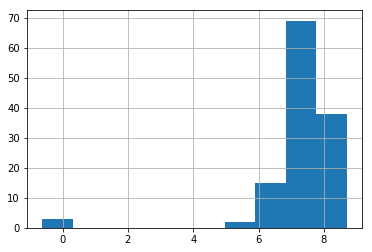

Clone-by-clone Analysis of gene expression for TRBV9
Analysis of expression for gene TRBV9 among clonotype A7
--------------------------------------------
Out of 43 individuals, there are  43 zeros.
Gene not expressed!
-------------------
Analysis of expression for gene TRBV9 among clonotype A8
--------------------------------------------
Out of 30 individuals, there are  30 zeros.
Gene not expressed!
-------------------
Analysis of expression for gene TRBV9 among clonotype B4
--------------------------------------------
Out of 42 individuals, there are  39 zeros.
On a log-scale, the nonzero gene expressions are below.


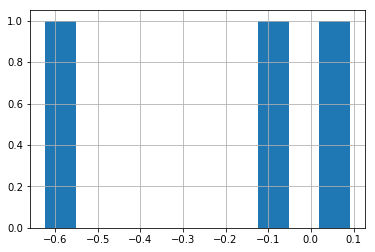

Analysis of expression for gene TRBV9 among clonotype E4
--------------------------------------------
Out of 44 individuals, there are  44 zeros.
Gene not expressed!
-------------------
Analysis of expression for gene TRBV9 among clonotype F3
--------------------------------------------
Out of 46 individuals, there are  0 zeros.
On a log-scale, the nonzero gene expressions are below.


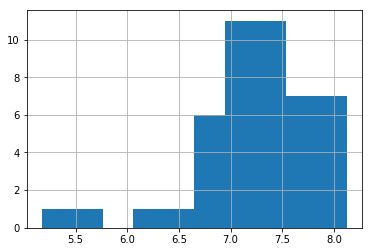

Analysis of expression for gene TRBV9 among clonotype G6
--------------------------------------------
Out of 31 individuals, there are  31 zeros.
Gene not expressed!
-------------------
Analysis of expression for gene TRBV9 among clonotype G8
--------------------------------------------
Out of 31 individuals, there are  31 zeros.
Gene not expressed!
-------------------
Analysis of expression for gene TRBV9 among clonotype H2
--------------------------------------------
Out of 45 individuals, there are  0 zeros.
On a log-scale, the nonzero gene expressions are below.


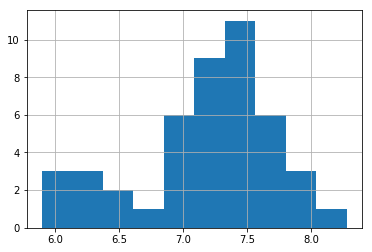

Analysis of expression for gene TRBV9 among clonotype H9
--------------------------------------------
Out of 33 individuals, there are  0 zeros.
On a log-scale, the nonzero gene expressions are below.


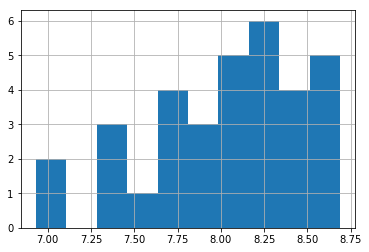

In [41]:
clonalyze('TRBV9') # carry out clone-by-clone analysis of this gene.  
#  This looks like an on/off gene, I guess.

## Analysis via latent semantic indexing with GENSIM.

Now I'm going to try and use gensim to carry out some dimensional reduction via latent semantic analysis.

In [42]:
# Load gensim packages.
from gensim import models, corpora, similarities
from gensim.test.utils import get_tmpfile

In [44]:
# I'll want a list of cell IDs.
cells = list(df.index)
print "The first five cell IDs are",cells[:5]
print len(cells),"cells are present." # The number of cells.

The first five cell IDs are ['P1902_1293', 'P1902_1294', 'P1902_1295', 'P1902_1296', 'P1902_1301']
345 cells are present.


In [45]:
# Put the gene-expression data in its own data frame.
genedf = df[genes].copy()
print genedf.shape # Number of cells, Number of genes.

(345, 19869)


In [46]:
# Put the gene-names into a gensim dictionary.
dictionary = corpora.Dictionary([[gene] for gene in genes])
print dictionary

Dictionary(19869 unique tokens: [u'RNF14', u'HIF3A', u'RNF17', u'RNF10', u'RNF11']...)


In [47]:
# Transform gene expression data on log-scale.
# Cut off all gene-expression less than 1.
# Thus the log-scaled gene-expression is 0 or greater.
genedf[genedf < 1] = 1
genedf = genedf.transform(np.log)

In [49]:
# We omit genes that are very rarely expressed.

genes_relevant = []
for gene in genes:
    if genedf[gene].mean() > 0.05:
        genes_relevant.append(gene)

print len(genes_relevant),"relevant genes found among",len(genes),"genes."
genedf = genedf[genes_relevant]  # Throw away all but the relevant genes.

12587 relevant genes found among 19869 genes.


Now we use the data frame to create a bag-of-words style corpus.  The result is an array of arrays.  Each entry is a list of the nonzero (with cutoffs) gene expressions of a cell, as a list of ordered pairs.  This will take a minute to run.

Basically, this is taking a data frame with a few million entries, and putting into a vector representation for LSI.

In [51]:
#  Get some coffee while this cell executes.
genecorpus = [[(dictionary.token2id[gene], genedf[gene][cell]) 
               for gene in genes_relevant 
               if genedf[gene][cell] > 0] for cell in cells]

In [52]:
genecorpus[0][:5] # The first five genes expressed by the cell P1902_1293.  
# (a,e) stands for relevant gene number a, with log-expression level e.

[(3, 2.1089358418411659),
 (13, 5.6202125882114444),
 (15, 5.9632312143909658),
 (25, 5.7035583478750036),
 (36, 0.94312679431663637)]

Now that we've got a nice corpus of gene expression, we separate it into training and testing (validation) subsets.

In [68]:
train_fraction = 0.75 # Put this proportion of the cells into the training set.  
# The rest are used for validation.

train_mask = np.random.choice([True, False], len(genecorpus), 
                              p=[train_fraction, 1 - train_fraction])
test_mask = [not b for b in train_mask]

# Separates the gene corpus into training and testing corpora.
corpus_train = [genecorpus[j] for j in range(len(genecorpus)) if train_mask[j]]
corpus_test = [genecorpus[j] for j in range(len(genecorpus)) if test_mask[j]]

# For future reference.
size_train = len(corpus_train)
size_test = len(corpus_test)

print "Training on ",size_train,"cells."
print size_test,"cells will be used for validation."

Training on  264 cells.
81 cells will be used for validation.


The following function is meant to predict the clonotype of a given cell.  It uses a not-yet-defined LSI model.  But we put the function here for later use, so that we can run and rerun what comes later without redefining the function.

In [69]:
def predict_clonotype(i):
    '''
    Predicts the clonotype of cell #i from the gene corpus.
    '''
    Total_dict = {clone : 0 for clone in clones}
    Count_dict = {clone : 0 for clone in clones}
    AVE_dict = {clone : 0 for clone in clones}
    t = 0
    for j in range(len(cells)):
        if train_mask[j]:
            clonotype = df['clonality'][j]
            Count_dict[clonotype] += 1
            # Note lsi[genecorpus[i]] is the projection of genecorpus[i] 
            # via the previous LSI model.
            # index gives the similarity.
            Total_dict[clonotype] += index[lsi[genecorpus[i]]][t]
            t += 1
    for clone in clones:
        AVE_dict[clone] = Total_dict[clone] / Count_dict[clone]
    return max(AVE_dict.iterkeys(), key=(lambda key: AVE_dict[key]))

To prep the training data, We carry out a TFIDF (term frequency–inverse document frequency) weighting on the training corpus.  Roughly speaking, this weights the expressed genes by their overall frequency (regardless of clonotype).  

In [70]:
tfidf = models.TfidfModel(corpus_train)
weighted_corpus = tfidf[corpus_train]

### Start here to experiment with model parameters.

LSI is used to reduce from 10000+ gene-expressions to a small number of "hidden" numerical properties (features) of each cell.  It's like PCA in some ways.  It's good to experiment with the number of features, to see what leads to the best predictive power.  There's some art to choosing hyperparameters like the number of features, and I don't have a good idea besides blind experimentation.

In [75]:
num_features = 10 # 11 worked best in testing. 
# Use LSI to reduce from 10000+ gene expressions to this number of features.

In [76]:
# The LSI model will be distinguishing clonotypes by certain features.
# These features are weighted combinations of gene expressions.
# The features are described below.
# This might take 10 seconds or so to run.

lsi = models.lsimodel.LsiModel(corpus=weighted_corpus, id2word=dictionary, 
                               num_topics=num_features, 
                               onepass = False, power_iters=3, extra_samples=100)

all_features = lsi.print_topics(num_features)
for j in range(num_features):
    print "Feature ",j," is: ",all_features[j][1]

Feature  0  is:  0.023*"TRBV9" + 0.022*"TRAV12-2" + 0.019*"TRAV27" + 0.019*"FCGR3A" + 0.019*"KLRB1" + 0.019*"BPGM" + 0.018*"SYNE2" + 0.018*"GPN1" + 0.018*"CCT7" + 0.018*"PVRIG"
Feature  1  is:  -0.091*"STMN1" + -0.088*"ZWINT" + -0.081*"UBE2C" + -0.081*"CTD-2116N17.1" + -0.079*"MKI67" + -0.078*"TK1" + -0.078*"CDKN3" + -0.077*"FEN1" + -0.077*"TOP2A" + -0.074*"CCNB2"
Feature  2  is:  0.153*"TRBV28" + 0.119*"TRAV12-1" + -0.106*"TRAV5" + 0.083*"PATL2" + 0.080*"CX3CR1" + 0.074*"TRAV12-3" + 0.073*"SELL" + 0.072*"S1PR1" + 0.070*"TRBJ1-2" + 0.068*"TRAJ20"
Feature  3  is:  -0.153*"TRDC" + -0.146*"TRDV3" + -0.107*"TRDJ3" + -0.096*"TRAJ47" + -0.091*"TRBV9" + 0.088*"TRBV27" + -0.085*"TRGV10" + -0.080*"TRAV27" + -0.072*"CD200R1" + -0.062*"TRGV1"
Feature  4  is:  0.112*"TRAV5" + -0.103*"TRAV12-2" + -0.081*"TRBV4-2" + 0.078*"TRBV28" + -0.076*"TRGV11" + -0.065*"TRAV14DV4" + -0.064*"CCR2" + -0.058*"JAML" + 0.057*"CD40LG" + -0.056*"REG4"
Feature  5  is:  0.140*"TRBV12-4" + 0.126*"TRAV9-2" + -0.110*"TRAV4

It might be interesting to see which genes the LSI algorithm has picked out, among the 10000+ ones.  These genes occur in the features above, and they are chosen for their power to distinguish.  Note that clonotypes are not being used to generate the above features!

Next, we produce an "index" to compare any gene-expression profile to a profile in the training set

In [77]:
index_tmpfile = get_tmpfile("index")
index = similarities.Similarity(index_tmpfile, lsi[weighted_corpus], num_features=num_features) # build the index
print index

Similarity index with 264 documents in 0 shards (stored under /var/folders/c0/wm_vsqfx5d52904q2v3fz6bm0000gn/T/index)


Essentially, LSI gives us a way of measuring similarity between two gene-expression profiles.  In order to guess which clonotype a cell belongs to, we can average its similarity to all cells of clonotype A7, to all cells from A8, etc..  If a cell is, on average, more similar (in gene expression) to those of clonotype A7, we put it in that clonotype.  

To see if this works, we use the test-code below.  It takes a minute or two to run.

In [78]:
# Check twitter while this runs.

S = 0
count = 0
for i in range(len(cells)):
    if test_mask[i]:
        count += 1
        actual = df['clonality'][i]
        pred = predict_clonotype(i)
        if actual == pred:
            S += 1
srate = float(S*100) / count
print size_test,'cells placed into',len(clones),'clonotypes by genetic data.'
print 'Accuracy of',srate,'% achieved with',num_features,'features in LSI reduction.'

81 cells placed into 9 clonotypes by genetic data.
Accuracy of 70.3703703704 % achieved with  10 features in LSI reduction.


Well, that's better than the accuracy of 11% one would expect by chance.